# Thesis Project: Automated Call Classification
##### MISIS: M00736335
##### CST 4090

In [216]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer # Feature extraction
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression # Train logistic regression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk

In [188]:
# Suppress ConvergenceWarnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

### 2. Data Preparation

In [82]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context


In [84]:
filePath = 'Emergency_call_Final_data.csv'
df = pd.read_csv(filePath)

In [85]:
print(df.head())

               Call Type                                      Transcription
0         Emergency call  This is the Bulkovia bank of 13 two west Inter...
1  Not an emergency call  Yes, we're at the Nelson building, and there's...
2  Not an emergency call  Listen, we're really bad, okay? You got attack...
3  Not an emergency call  I'm walking in the field. I don't know where I...
4         Emergency call  Somebody just sent the police officer. Okay, w...


In [142]:
df = df.drop('Call Type', axis=1)

In [86]:
df.count()

Call Type        539
Transcription    539
dtype: int64

In [87]:
# Inspect column names
print("\nColumn names:")
print(df.columns)


Column names:
Index(['Call Type', 'Transcription'], dtype='object')


In [215]:
print("\nData types of each column:") # Check the data types of each column
print(df.dtypes)


Data types of each column:
Transcription             object
Tokens                    object
VaderSentimentScore      float64
Vader Sentiment Score    float64
TextBlob Polarity        float64
TextBlob Subjectivity    float64
TextBlobPolarity         float64
TextBlobSubjectivity     float64
Type                       int64
dtype: object


In [89]:
print("\nMissing values in each column:")
print(df.isnull().sum())


Missing values in each column:
Call Type        0
Transcription    0
dtype: int64


### 3. Data Preprocessing

In [91]:
# Downloading necessary NLTK data files
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/firdousmohammed/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/firdousmohammed/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/firdousmohammed/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [217]:
lemmatizr = WordNetLemmatizer() # Initialize the lemmatizer and stop words list
stopWo = set(stopwords.words('english'))

In [94]:
# text preprocessing
def preprocess(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ''.join([char for char in text if not char.isdigit()])
    text = ' '.join(word for word in text.split() if word not in stopWo)
    text = ' '.join(lemmatizr.lemmatize(word) for word in word_tokenize(text))
    return text

In [95]:
# Apply on column
df['Transcription'] = df['Transcription'].apply(preprocess)

In [96]:
df['Tokens'] = df['Transcription'].apply(word_tokenize)

In [97]:
print("First few rows of the preprocessed text:")
print(df[['Transcription', 'Tokens']].head())

First few rows of the preprocessed text:
                                       Transcription  \
0  bulkovia bank two west international speedway ...   
1  yes nelson building there man adult came board...   
2         listen really bad okay got attacked people   
3  im walking field dont know youre walking field...   
4  somebody sent police officer okay whats addres...   

                                              Tokens  
0  [bulkovia, bank, two, west, international, spe...  
1  [yes, nelson, building, there, man, adult, cam...  
2  [listen, really, bad, okay, got, attacked, peo...  
3  [im, walking, field, dont, know, youre, walkin...  
4  [somebody, sent, police, officer, okay, whats,...  


### 4. Sentiment Analysis
1. VADER Sentiment Analysis

In [126]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [127]:
# Initialize
vadrAnalyzr = SentimentIntensityAnalyzer()

In [128]:
# Function to compute VADER sentiment score
def vaderSS(text):
    sentimentDict = vadrAnalyzr.polarity_scores(text)
    return sentimentDict['compound']

In [129]:
# Apply the VADER sentiment analysis
df['VaderSentimentScore'] = df['Transcription'].apply(vaderSS)

In [130]:
print("First few rows of VADER sentiment scores:")
print(df[['Transcription', 'VaderSentimentScore']].head())

First few rows of VADER sentiment scores:
                                       Transcription  VaderSentimentScore
0  bulkovia bank two west international speedway ...               0.2263
1  yes nelson building there man adult came board...               0.5574
2         listen really bad okay got attacked people              -0.6823
3  im walking field dont know youre walking field...               0.1531
4  somebody sent police officer okay whats addres...               0.2263


2. TextBlob Sentiment Analysis

In [131]:
from textblob import TextBlob

In [132]:
# Function to compute TextBlob polarity and subjectivity
def tbSentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity, blob.sentiment.subjectivity

In [133]:
# Apply TextBlob sentiment analysis
df['TextBlobPolarity'], df['TextBlobSubjectivity'] = zip(*df['Transcription'].apply(tbSentiment))

In [134]:
print("First few rows of TextBlob sentiment polarity and subjectivity:")
print(df[['Transcription', 'TextBlobPolarity', 'TextBlobSubjectivity']].head())

First few rows of TextBlob sentiment polarity and subjectivity:
                                       Transcription  TextBlobPolarity  \
0  bulkovia bank two west international speedway ...              0.25   
1  yes nelson building there man adult came board...              0.30   
2         listen really bad okay got attacked people             -0.10   
3  im walking field dont know youre walking field...              0.50   
4  somebody sent police officer okay whats addres...              0.50   

   TextBlobSubjectivity  
0              0.250000  
1              0.400000  
2              0.583333  
3              0.500000  
4              0.500000  


### 5. Determine Threshold for Classification

1. Histogram of VADER Sentiment Scores

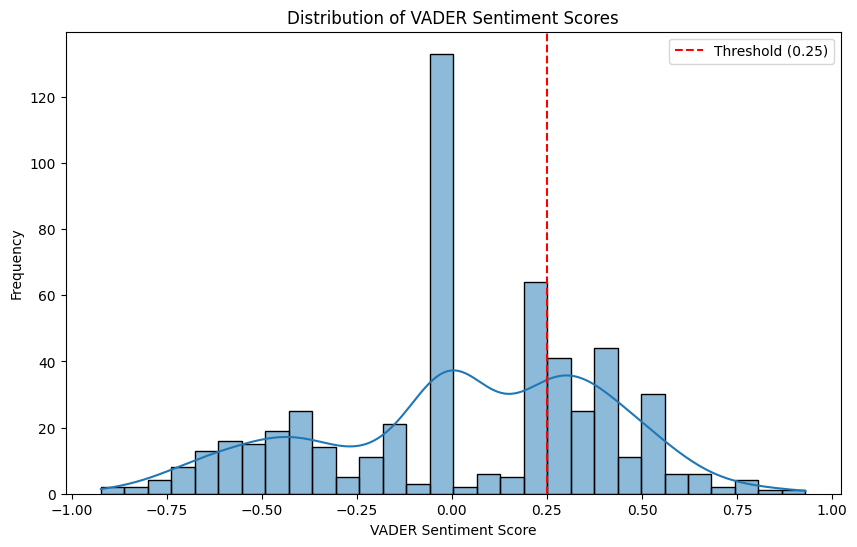

In [135]:
# Plot distribution of VADER sentiment scores
plt.figure(figsize=(10, 6))
sns.histplot(df['VaderSentimentScore'], bins=30, kde=True)
plt.title('Distribution of VADER Sentiment Scores')
plt.xlabel('VADER Sentiment Score')
plt.ylabel('Frequency')
plt.axvline(x=0.25, color='red', linestyle='--', label='Threshold (0.25)')
plt.legend()
plt.show()

2. Box Plot of VADER Sentiment Scores

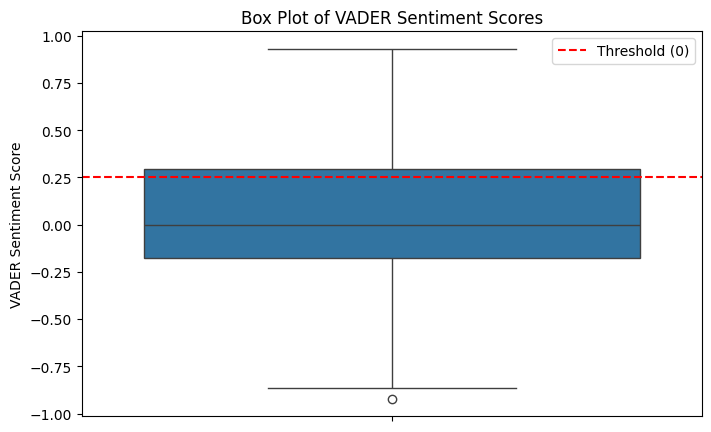

In [136]:
# BoxPlot
plt.figure(figsize=(8, 5))
sns.boxplot(y=df['VaderSentimentScore'])
plt.title('Box Plot of VADER Sentiment Scores')
plt.ylabel('VADER Sentiment Score')
plt.axhline(y=0.25, color='red', linestyle='--', label='Threshold (0)')
plt.legend()
plt.show()

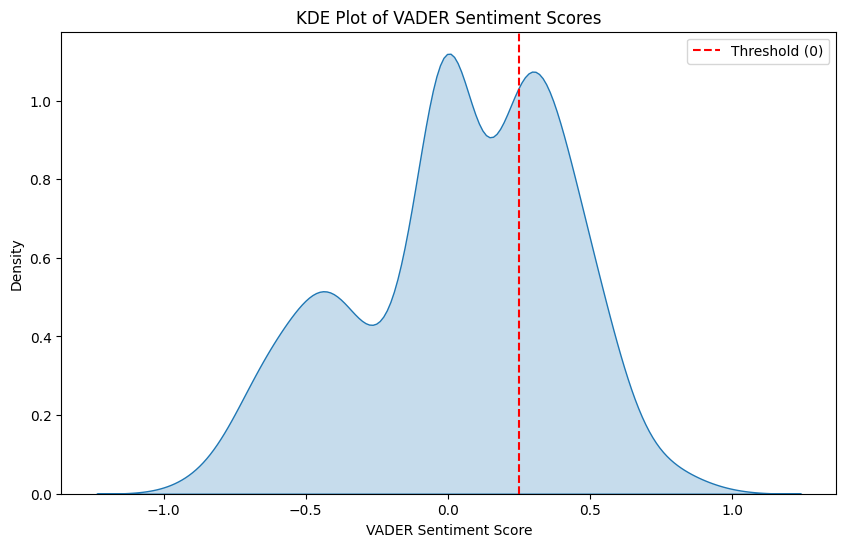

In [137]:
# Kernel Density Estimate
plt.figure(figsize=(10, 6))
sns.kdeplot(df['VaderSentimentScore'], fill=True)
plt.title('KDE Plot of VADER Sentiment Scores')
plt.xlabel('VADER Sentiment Score')
plt.ylabel('Density')
plt.axvline(x=0.25, color='red', linestyle='--', label='Threshold (0)')
plt.legend()
plt.show()

In [138]:
print(df['VaderSentimentScore'].describe())

count    539.000000
mean       0.038675
std        0.366710
min       -0.923100
25%       -0.177900
50%        0.000000
75%        0.296000
max        0.930000
Name: VaderSentimentScore, dtype: float64


### 6. Creating a Type column

In [139]:
# Defining threshold
threshold = 0.25
# Apply thresholds to classify the calls
df['Type'] = df['VaderSentimentScore'].apply(lambda x: 'Emergency' if x < threshold else 'Non-Emergency')
print(df[['VaderSentimentScore', 'Type']].head())

   VaderSentimentScore           Type
0               0.2263      Emergency
1               0.5574  Non-Emergency
2              -0.6823      Emergency
3               0.1531      Emergency
4               0.2263      Emergency


In [143]:
df.head()

,Transcription,Tokens,VaderSentimentScore,Vader Sentiment Score,TextBlob Polarity,TextBlob Subjectivity,TextBlobPolarity,TextBlobSubjectivity,Type
0,bulkovia bank two west international speedway ...,"[bulkovia, bank, two, west, international, spe...",0.2263,0.2263,0.25,0.250000,0.25,0.250000,Emergency
1,yes nelson building there man adult came board...,"[yes, nelson, building, there, man, adult, cam...",0.5574,0.5574,0.30,0.400000,0.30,0.400000,Non-Emergency
2,listen really bad okay got attacked people,"[listen, really, bad, okay, got, attacked, peo...",-0.6823,-0.6823,-0.10,0.583333,-0.10,0.583333,Emergency
3,im walking field dont know youre walking field...,"[im, walking, field, dont, know, youre, walkin...",0.1531,0.1531,0.50,0.500000,0.50,0.500000,Emergency
4,somebody sent police officer okay whats addres...,"[somebody, sent, police, officer, okay, whats,...",0.2263,0.2263,0.50,0.500000,0.50,0.500000,Emergency


Label Encoding

In [144]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['Type'] = label_encoder.fit_transform(df['Type'])  # Converts 'Emergency' to 1, 'Non-Emergency' to 0

### 7. Classification models

1. Logistic Regression

In [146]:
# Initialize TF-IDF Vectorizer
tfVector = TfidfVectorizer()
# Fit and transform the text data
X = tfVector.fit_transform(df['Transcription'])

In [153]:
# Define features and target
X = tfVector.transform(df['Transcription'])
y = df['Type']
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [156]:
logisticM = LogisticRegression()
# Train the model
logisticM.fit(X_train, y_train)

LogisticRegression()

In [173]:
# Make predictions
y_pred = logisticModel.predict(X_test)
# Compute and display metrics
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("Accuracy Score:")
print(accuracy_score(y_test, y_pred))

Confusion Matrix:
[[77  0]
 [12 19]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      1.00      0.93        77
           1       1.00      0.61      0.76        31

    accuracy                           0.89       108
   macro avg       0.93      0.81      0.84       108
weighted avg       0.90      0.89      0.88       108

Accuracy Score:
0.8888888888888888


#### Cross Validation

In [163]:
# Number of folds
nfolds = 5
# Initialize
kf = KFold(n_splits=nfolds, shuffle=True, random_state=42)
# Accuracy for classification tasks
cvscores = cross_val_score(logisticM, X, y, cv=kf, scoring='accuracy')
print("Cross-validation scores for Logistic Regression:", cvscores)
print("Mean Accuracy (Logistic Regression):", cvscores.mean())

Cross-validation scores for Logistic Regression: [0.88888889 0.84259259 0.89814815 0.89814815 0.86915888]
Mean Accuracy (Logistic Regression): 0.8793873312564902


2. Decision Tree

In [166]:
# Initialize
decisionTreeM = DecisionTreeClassifier()
decisionTreeM.fit(X_train, y_train)

DecisionTreeClassifier()

In [172]:
# Make predictions
y_pred = decisionTreeM.predict(X_test)
# Compute and display metrics
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("Accuracy Score:")
print(accuracy_score(y_test, y_pred))

Confusion Matrix:
[[72  5]
 [ 4 27]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.94        77
           1       0.84      0.87      0.86        31

    accuracy                           0.92       108
   macro avg       0.90      0.90      0.90       108
weighted avg       0.92      0.92      0.92       108

Accuracy Score:
0.9166666666666666


Cross Validation

In [175]:
# Number of folds
nfolds = 5
# Initialize
kf = KFold(n_splits=nfolds, shuffle=True, random_state=42)
cvscores = cross_val_score(decisionTreeM, X, y, cv=kf, scoring='accuracy')
print("Cross-validation scores for Decision Tree:", cvscores)
print("Mean Accuracy (Decision Tree):", cvscores.mean())

Cross-validation scores for Decision Tree: [0.91666667 0.94444444 0.96296296 0.87962963 0.92523364]
Mean Accuracy (Decision Tree): 0.9257874697127033


3. Random Forest

In [176]:
# Initialize Random Forest model
randomForestM = RandomForestClassifier()
# Train the model
randomForestM.fit(X_train, y_train)

RandomForestClassifier()

In [178]:
y_pred = randomForestM.predict(X_test)
# Compute and display metrics
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("Accuracy Score:")
print(accuracy_score(y_test, y_pred))

Confusion Matrix:
[[75  2]
 [ 9 22]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.97      0.93        77
           1       0.92      0.71      0.80        31

    accuracy                           0.90       108
   macro avg       0.90      0.84      0.87       108
weighted avg       0.90      0.90      0.89       108

Accuracy Score:
0.8981481481481481


Cross Validation

In [179]:
# Number of folds
nfolds = 5
# Initialize
kf = KFold(n_splits=nfolds, shuffle=True, random_state=42)
cvscores = cross_val_score(randomForestM, X, y, cv=kf, scoring='accuracy')
print("Cross-validation scores for Random Forest:", cvscores)
print("Mean Accuracy (Random Forest):", cvscores.mean())

Cross-validation scores for Random Forest: [0.89814815 0.90740741 0.97222222 0.90740741 0.90654206]
Mean Accuracy (Random Forest): 0.9183454482519903


4. Support Vector Machine (SVM)


In [184]:
polyM = SVC(kernel='poly', C=1)
linearM = SVC(kernel='linear', C=1)
SigmoidM = SVC(kernel='sigmoid', C=1)

In [181]:
polyM.fit(X_train, y_train.ravel())
linearM.fit(X_train, y_train.ravel())
SigmoidM.fit(X_train, y_train.ravel())

SVC(C=1, kernel='sigmoid')

In [182]:
y_pred_poly = Model_poly.predict(X_test)
y_pred_linear = Model_linear.predict(X_test)
y_pred_sigmoid = Model_sigmoid.predict(X_test)

In [183]:
print("Polynomial Kernel SVM:")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_poly))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_poly))
print("Accuracy Score:")
print(accuracy_score(y_test, y_pred_poly))
print("\n" + "-"*50 + "\n")
print("Linear Kernel SVM:")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_linear))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_linear))
print("Accuracy Score:")
print(accuracy_score(y_test, y_pred_linear))
print("\n" + "-"*50 + "\n")
print("Sigmoid Kernel SVM:")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_sigmoid))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_sigmoid))
print("Accuracy Score:")
print(accuracy_score(y_test, y_pred_sigmoid))
print("\n" + "-"*50 + "\n")

Polynomial Kernel SVM:
Confusion Matrix:
[[77  0]
 [12 19]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      1.00      0.93        77
           1       1.00      0.61      0.76        31

    accuracy                           0.89       108
   macro avg       0.93      0.81      0.84       108
weighted avg       0.90      0.89      0.88       108

Accuracy Score:
0.8888888888888888

--------------------------------------------------

Linear Kernel SVM:
Confusion Matrix:
[[75  2]
 [ 9 22]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.97      0.93        77
           1       0.92      0.71      0.80        31

    accuracy                           0.90       108
   macro avg       0.90      0.84      0.87       108
weighted avg       0.90      0.90      0.89       108

Accuracy Score:
0.8981481481481481

--------------------------------------------------

Sigmoi

Cross Validation

In [186]:
# Number of folds
nfolds = 5
# Cross-validation
kf = KFold(n_splits=nfolds, shuffle=True, random_state=42)

# Cross-validation for Polynomial Kernel
cvscoresPoly = cross_val_score(Model_poly, X_train, y_train.ravel(), cv=kf, scoring='accuracy')
print("Cross-validation scores for Polynomial Kernel:", cvscoresPoly)
print("Mean Accuracy (Polynomial Kernel):", cvscoresPoly.mean())
print("\n" + "-"*50 + "\n")

# Cross-validation for Linear Kernel
cvscoresLinear = cross_val_score(Model_linear, X_train, y_train.ravel(), cv=kf, scoring='accuracy')
print("Cross-validation scores for Linear Kernel:", cvscoresLinear)
print("Mean Accuracy (Linear Kernel):", cvscoresLinear.mean())
print("\n" + "-"*50 + "\n")

# Cross-validation for Sigmoid Kernel
cvscoresSigmoid = cross_val_score(Model_sigmoid, X_train, y_train.ravel(), cv=kf, scoring='accuracy')
print("Cross-validation scores for Sigmoid Kernel:", cvscoresSigmoid)
print("Mean Accuracy (Sigmoid Kernel):", cvscoresSigmoid.mean())
print("\n" + "-"*50 + "\n")

Cross-validation scores for Polynomial Kernel: [0.95402299 0.88372093 0.93023256 0.86046512 0.84883721]
Mean Accuracy (Polynomial Kernel): 0.895455760491847

--------------------------------------------------

Cross-validation scores for Linear Kernel: [0.93103448 0.91860465 0.96511628 0.95348837 0.89534884]
Mean Accuracy (Linear Kernel): 0.9327185244587008

--------------------------------------------------

Cross-validation scores for Sigmoid Kernel: [0.93103448 0.90697674 0.95348837 0.94186047 0.88372093]
Mean Accuracy (Sigmoid Kernel): 0.9234161988773055

--------------------------------------------------



### 8. Compare Results

to be done

### 9. Hyperparameter Tuning

In [190]:
# Logistic Regression
paramGridLogis = {
    'C': [0.001, 0.01, 0.1, 1, 10],  
    'solver': ['liblinear', 'saga']
}

logisticM = LogisticRegression(max_iter=1000)

gridSearchLogis = GridSearchCV(logisticM, paramGridLogis, cv=5, scoring='accuracy')
gridSearchLogis.fit(X_train, y_train)

print("Best parameters for Logistic Regression:", gridSearchLogis.best_params_)
print("Best score for Logistic Regression:", gridSearchLogis.best_score_)

bestLogisticM = gridSearchLogis.best_estimator_
logisticPredict = bestLogisticM.predict(X_test)

Best parameters for Logistic Regression: {'C': 10, 'solver': 'liblinear'}
Best score for Logistic Regression: 0.9258754343758353


In [191]:
# Decision Tree
paramGridDecisionT = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

decisionTreeM = DecisionTreeClassifier()

gridSearchDecisionT = GridSearchCV(decisionTreeM, paramGridDecisionT, cv=5, scoring='accuracy')
gridSearchDecisionT.fit(X_train, y_train)

print("Best parameters for Decision Tree:", gridSearchDecisionT.best_params_)
print("Best score for Decision Tree:", gridSearchDecisionT.best_score_)

bestDecisionTreeM = gridSearchDecisionT.best_estimator_
decisionTreePredict = bestDecisionTreeM.predict(X_test)

Best parameters for Decision Tree: {'criterion': 'entropy', 'max_depth': 30, 'min_samples_split': 5}
Best score for Decision Tree: 0.9258219727345629


In [192]:
# Random Forest
paramGridRandomF = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}

randomForestM = RandomForestClassifier()

gridSearchRandomF = GridSearchCV(randomForestM, paramGridRandomF, cv=5, scoring='accuracy')
gridSearchRandomF.fit(X_train, y_train)

print("Best parameters for Random Forest:", gridSearchRandomF.best_params_)
print("Best score for Random Forest:", gridSearchRandomF.best_score_)

bestRandomForestM = gridSearchRandomF.best_estimator_
randomForestPredict = bestRandomForestM.predict(X_test)

Best parameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best score for Random Forest: 0.9351242983159583


In [193]:
paramGridSVM = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3, 4]
}

svmM = SVC()

gridSearchSVM = GridSearchCV(svmM, param_grid=paramGridSVM, cv=5, scoring='accuracy')
gridSearchSVM.fit(X_train, y_train)

print("Best parameters for SVM:", gridSearchSVM.best_params_)
print("Best score for SVM:", gridSearchSVM.best_score_)

bestSVMM = gridSearchSVM.best_estimator_
svmPredict = bestSVMM.predict(X_test)

Best parameters for SVM: {'C': 10, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}
Best score for SVM: 0.9235498529804864


### LSTM

In [203]:
tokenizr = Tokenizer() # Create a tokenizer and fit on the tokenized words
flat_tokens = [token for sublist in df['Tokens'].values for token in sublist] # Flatten the list of tokens and fit the tokenizer
tokenizr.fit_on_texts(flat_tokens)
X = tokenizr.texts_to_sequences(df['Tokens'].apply(lambda x: ' '.join(x)))# Convert token lists to sequences
X = pad_sequences(X, padding='post')# Padding sequences to make them of equal length

In [204]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [205]:
model = Sequential() # Define the LSTM model
vocab_size = len(tokenizer.word_index) + 1  # +1 for padding token
embedding_dim = 50  
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=X.shape[1])) # Add an embedding layer
model.add(LSTM(units=64, return_sequences=False)) # Add LSTM layer with fewer units to avoid overfitting
model.add(Dropout(0.3))  # Dropout layer to reduce overfitting
model.add(Dense(1, activation='sigmoid'))  # Add Dense output layer, Sigmoid activation for binary classification
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # Compile the model
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 17, 50)            34600     
                                                                 
 lstm_4 (LSTM)               (None, 64)                29440     
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 64105 (250.41 KB)
Trainable params: 64105 (250.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [206]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2) # Train the LSTM model

Epoch 1/10
11/11 [==============================] - 2s 61ms/step - loss: 0.6769 - accuracy: 0.6395 - val_loss: 0.6742 - val_accuracy: 0.5747
Epoch 2/10
11/11 [==============================] - 0s 13ms/step - loss: 0.6227 - accuracy: 0.6657 - val_loss: 0.6863 - val_accuracy: 0.5747
Epoch 3/10
11/11 [==============================] - 0s 12ms/step - loss: 0.5713 - accuracy: 0.6657 - val_loss: 0.5507 - val_accuracy: 0.5977
Epoch 4/10
11/11 [==============================] - 0s 12ms/step - loss: 0.3109 - accuracy: 0.8692 - val_loss: 0.3837 - val_accuracy: 0.8736
Epoch 5/10
11/11 [==============================] - 0s 12ms/step - loss: 0.1414 - accuracy: 0.9622 - val_loss: 0.4844 - val_accuracy: 0.8736
Epoch 6/10
11/11 [==============================] - 0s 12ms/step - loss: 0.0806 - accuracy: 0.9797 - val_loss: 0.4736 - val_accuracy: 0.8851
Epoch 7/10
11/11 [==============================] - 0s 12ms/step - loss: 0.0375 - accuracy: 0.9942 - val_loss: 0.3895 - val_accuracy: 0.9195
Epoch 8/10
11

In [207]:
loss, accuracy = model.evaluate(X_test, y_test) # Evaluate the model on the test set
print('Test Accuracy: {:.4f}'.format(accuracy))

4/4 [==============================] - 0s 5ms/step - loss: 0.3546 - accuracy: 0.9259
Test Accuracy: 0.9259


In [208]:
y_pred = model.predict(X_test) # Predict on the test set
y_pred = np.round(y_pred).astype(int)  # Convert probabilities to 0 or 1
y_pred_labels = label_encoder.inverse_transform(y_pred.flatten()) # Convert predictions back to labels

4/4 [==============================] - 0s 6ms/step


4/4 [==============================] - 0s 4ms/step


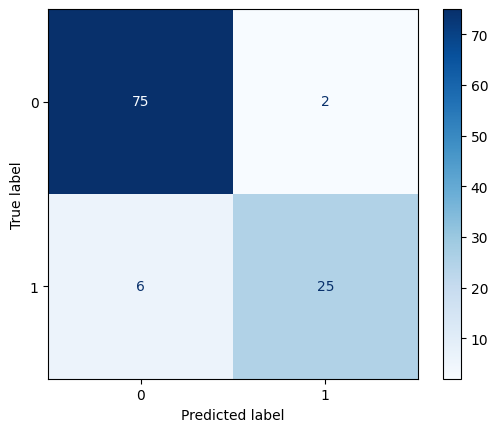

In [210]:
y_test_pred = (model.predict(X_test) > 0.5).astype(int) # Predict on the test set
# Compute confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

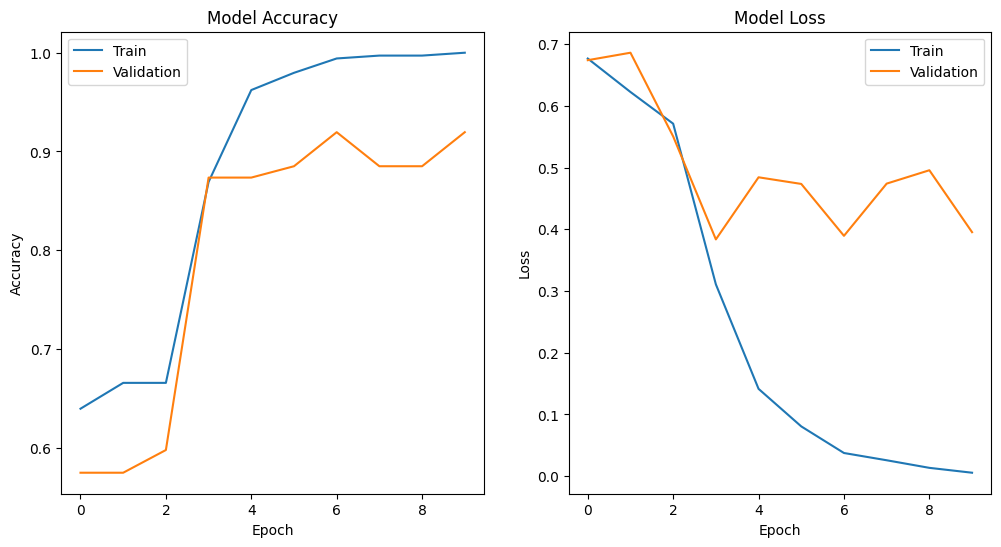

In [212]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

In [213]:
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0) # Check final metrics
val_loss, val_accuracy = model.evaluate(X_test, y_test, verbose=0)

print('Training Loss: {:.4f}, Training Accuracy: {:.4f}'.format(train_loss, train_accuracy))
print('Validation Loss: {:.4f}, Validation Accuracy: {:.4f}'.format(val_loss, val_accuracy))

Training Loss: 0.0842, Training Accuracy: 0.9838
Validation Loss: 0.3546, Validation Accuracy: 0.9259


In [214]:
y_pred_prob = model.predict(X_test) # Predict class labels on the test set
y_pred_class = (y_pred_prob > 0.5).astype("int32")  # Convert probabilities to binary class (0 or 1)
print("Classification Report:")
print(classification_report(y_test, y_pred_class))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_class))

4/4 [==============================] - 0s 4ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95        77
           1       0.93      0.81      0.86        31

    accuracy                           0.93       108
   macro avg       0.93      0.89      0.91       108
weighted avg       0.93      0.93      0.92       108

Confusion Matrix:
[[75  2]
 [ 6 25]]
